


*   Código para cálculo de correção atmosférica por modelo empírico (DOS).
*   Além da correção, o código contempla a comparação entre o método implementado e o derivado da biblioteca RSGISlib, utilizado no workshop.



*   A comparação foi feita por similaridade entre histogramas e estatística descritiva das bandas. 🛰 📡 🌎





---


Autores: Carlos Lamarque, Gustavo Ferreira e Gustavo Baptista




# Construção da função do método DOS (primeira abordagem)

In [7]:
#Instalação de bibliotecas
!pip install spectral -q
!pip install rasterio -q

     |████████████████████████████████| 212 kB 5.2 MB/s 
     |████████████████████████████████| 19.3 MB 381 kB/s 


In [8]:
# Importação de bibliotecas/métodos 
from spectral import imshow
import tifffile as tif
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt


In [ ]:
# Leitura das imagens original
img_ori = tif.imread('/content/drive/MyDrive/Colab Notebooks/Curso_PDI_Python/correção atmosférica/L71221071_07120010720_DN.tif')

In [ ]:
img_ori.shape

(6, 1233, 1520)

In [ ]:
# Metadados
img_original_meta = rio.open('/content/drive/MyDrive/Colab Notebooks/Curso_PDI_Python/correção atmosférica/L71221071_07120010720_DN.tif')
meta = img_original_meta.profile
meta

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1520, 'height': 1233, 'count': 6, 'crs': CRS.from_epsg(32723), 'transform': Affine(30.0, 0.0, 160665.0,
       0.0, -30.0, 8279275.0), 'tiled': False, 'interleave': 'band'}

In [ ]:
# Mudança de formato de bandas x linhas x colunas para linhas x colunas x bandas
img_ori1 = img_ori.swapaxes(1,0)
img_ori = img_ori1.swapaxes(2,1)
img_ori.shape

(1233, 1520, 6)

In [ ]:
# Obtenção de dados estatísticos
l_min=[]
l_per=[]
for i in range(img_ori.shape[2]):
  min = img_ori[:,:,i].min()
  l_min.append(min)
  per = (np.percentile(img_ori[:,:,i], 1))
  l_per.append(per)

In [ ]:
# Correção das bandas (usando um FOR melhora o código)
img_ori1 = img_ori[:, :, 0]
img_corr1 = img_ori1 - l_per[0]
img_corr1 = np.where(img_corr1 > 0, img_corr1, 1)

img_ori2 = img_ori[:, :, 1]
img_corr2 = img_ori2 - l_per[1]
img_corr2 = np.where(img_corr2 > 0, img_corr2, 1)

img_ori3 = img_ori[:, :, 2]
img_corr3 = img_ori3 - l_per[2]
img_corr3 = np.where(img_corr3 > 0, img_corr3, 1)

img_ori4 = img_ori[:, :, 3]
img_corr4 = img_ori4 - l_per[3]
img_corr4 = np.where(img_corr4 > 0, img_corr4, 1)

In [ ]:
# Empilhamento das bandas corrigidas
stack_img_corr1 = np.dstack([img_corr1, img_corr2, img_corr3, img_corr4, img_corr5, img_corr7])

In [ ]:
# Visualização de uma composição colorida da imagem corrigida
imshow(stack_img_corr1 , (2,3,1), figsize=(12,8))

In [ ]:
# Voltando para o formato bandas x linhas x colunas
stack_lama = stack_img_corr1.swapaxes(2,1)
stack_lama = stack_lama.swapaxes(1,0)
stack_lama.shape

In [ ]:
# Gravação da imagem corrigida em disco
with rio.open('imagem_corr_Lama.tif', 'w', **meta) as src:
  src.write(stack_lama)

# Código retrabalhado

In [ ]:
# Padronizando tamanho de figuras
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)

In [ ]:
# Funções para redimensionamento
from rasterio.plot import reshape_as_image, reshape_as_raster

In [ ]:
# Lendo imagem empilhada
with rio.open('/content/drive/MyDrive/Dados_CBERS/stack.tif') as src:
  cbers = src.read()
  meta = src.profile

In [ ]:
cbers.shape

(4, 3306, 3395)

In [ ]:
meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 0.0, 'width': 3395, 'height': 3306, 'count': 4, 'crs': CRS.from_epsg(32723), 'transform': Affine(8.0, 0.0, 165706.0,
       0.0, -8.0, 8276482.0), 'tiled': False, 'interleave': 'pixel'}

In [ ]:
# Redimensionando
cbers_reshape = reshape_as_image(cbers)
cbers_reshape.shape

(3306, 3395, 4)

In [ ]:
x = np.empty_like(cbers_reshape)

In [ ]:
x

In [ ]:
cbers_reshape.shape[2]

4

In [ ]:
# Função para a correção atmosférica
def DOS(img, perc=1):
  l_per = []
  img_corr = np.zeros_like(img)
  for i in range(img.shape[2]):
    per = (np.percentile(img[:,:,i], perc))
    l_per.append(per)
    img_corr[:,:,i] = img[:,:,i] - l_per[i]
    img_corr[:,:,i] = np.where(img_corr[:,:,i] > 0, img_corr[:,:,i] , 0)
    print(l_per)
  return img_corr

In [ ]:
# Aplicando função
dos = DOS(cbers_reshape)

[223.0]
[223.0, 176.0]
[223.0, 176.0, 152.0]
[223.0, 176.0, 152.0, 137.0]


In [ ]:
dos.shape

(3306, 3395, 4)

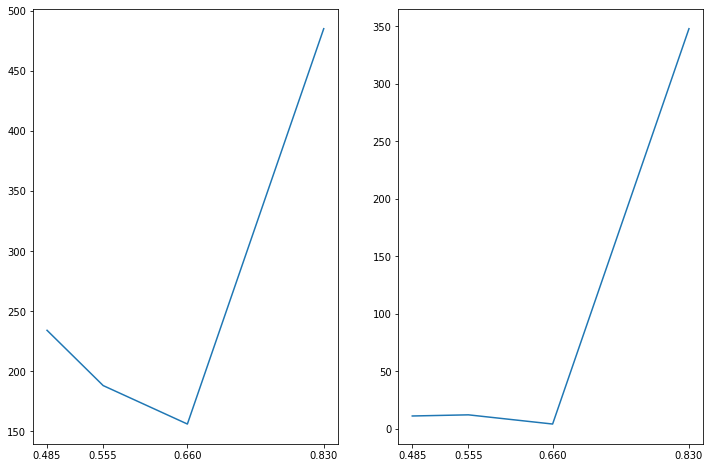

In [ ]:
# Visualizando espectros
x = [0.485, 0.555, 0.66, 0.83]

fig, ax = plt.subplots(1,2)
ax[0].plot(x, cbers_reshape[1758,2146,:])
ax[0].set_xticks(x)
ax[1].plot(x, dos[1758,2146,:])
ax[1].set_xticks(x)
plt.show()

ImageView object:
  Display bands       :  (2, 1, 0)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 871.0]
    G: [0.0, 847.0]
    B: [0.0, 800.0]

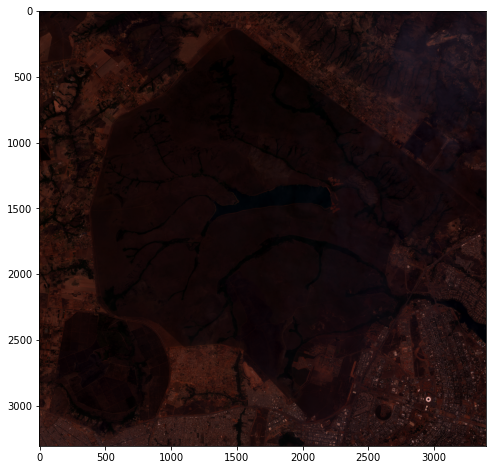

In [ ]:
# Visualização de uma composição colorida da imagem corrigida
imshow(dos, (2,1,0))

ImageView object:
  Display bands       :  (2, 1, 0)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1023.0]
    G: [0.0, 1023.0]
    B: [0.0, 1023.0]

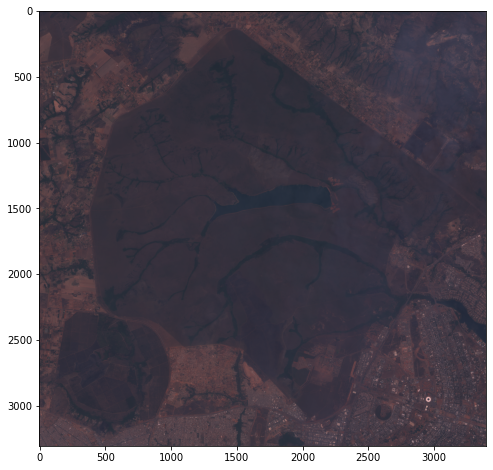

In [ ]:
# Visualização de uma composição colorida da imagem não corrigida
imshow(cbers_reshape, (2,1,0))

In [ ]:
# Redimensionando para formato legível pela rasterio
dos_raster = reshape_as_raster(dos)

In [ ]:
dos_raster.shape

(4, 3306, 3395)

In [ ]:
meta.update({'nodata':-9999})

In [ ]:
meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999, 'width': 3395, 'height': 3306, 'count': 4, 'crs': CRS.from_epsg(32723), 'transform': Affine(8.0, 0.0, 165706.0,
       0.0, -8.0, 8276482.0), 'tiled': False, 'interleave': 'pixel'}

In [ ]:
# Gravação da imagem corrigida em disco

with rio.open('cbers_DOS.tif', 'w', **meta) as src:
  src.write(dos_raster)

# Comparação entre histogramas

In [2]:
# Bibliotecas
import cv2
import tifffile as tif
import pandas as pd

In [3]:
# Lendo arquivos
DOS_1 = tif.imread('/content/drive/MyDrive/Dados_CBERS/cbers_DOS.tif')
DOS_2 = tif.imread('/content/drive/MyDrive/Dados_CBERS/DOS.tif')

In [4]:
# Calculando histogramas com OpenCV
DOS_1_hist = [cv2.calcHist([DOS_1[:,:,i].astype('float32')],[0],None,[500],[0.0,1023.0]) for i in range(DOS_1.shape[2])]
DOS_2_hist = [cv2.calcHist([DOS_2[:,:,i].astype('float32')],[0],None,[500],[0.0,1023.0]) for i in range(DOS_2.shape[2])]

In [ ]:
len(DOS_1_hist)

4

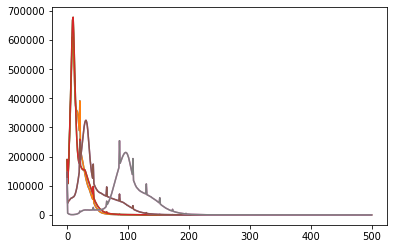

In [9]:
# Visualizando histogramas
for i in range(len(DOS_1_hist)):
  plt.plot(DOS_1_hist[i])
  plt.plot(DOS_2_hist[i])
plt.show()

In [10]:
# Calculando métricas de comparação
corr = [cv2.compareHist(DOS_1_hist[i], DOS_2_hist[i], cv2.HISTCMP_CORREL) for i in range(len(DOS_1_hist))]
chi = [cv2.compareHist(DOS_1_hist[i], DOS_2_hist[i], cv2.HISTCMP_CHISQR) for i in range(len(DOS_1_hist))]  
inter = [cv2.compareHist(DOS_1_hist[i], DOS_2_hist[i], cv2.HISTCMP_INTERSECT) for i in range(len(DOS_1_hist))] 
bhatt = [cv2.compareHist(DOS_1_hist[i], DOS_2_hist[i], cv2.HISTCMP_BHATTACHARYYA) for i in range(len(DOS_1_hist))]

In [12]:
# Armazenando métricas em um DataFrame
df = pd.DataFrame()
df['Método'] = ['Correlação', 'Chi-quadrado', 'Intersecção', 
                'Distância de Bhattacharyya']
  

df['B1'] = [corr[0],chi[0],inter[0],bhatt[0]]
df['B2'] = [corr[1],chi[1],inter[1],bhatt[1]]
df['B3'] = [corr[2],chi[2],inter[2],bhatt[2]]
df['B4'] = [corr[3],chi[3],inter[3],bhatt[3]]

In [13]:
# Visualizando DataFrame
df.head()

,Método,B1,B2,B3,B4
0,Correlação,1.0,1.0,1.0,1.0
1,Chi-quadrado,0.0,0.0,0.0,0.0
2,Intersecção,11223870.0,11223870.0,11223870.0,11223870.0
3,Distância de Bhattacharyya,0.0,0.0,0.0,0.0


# Estatística descritiva

In [ ]:
DOS_1.shape

(3306, 3395, 4)

In [ ]:
# Conversão de 3 dimensões para 2
DOS_1_2D = DOS_1.reshape(DOS_1.shape[0] * DOS_1.shape[1], DOS_1.shape[2])
DOS_2_2D = DOS_2.reshape(DOS_2.shape[0] * DOS_2.shape[1], DOS_2.shape[2])

In [ ]:
# Formatando saída de valores numéricos
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# Extraindo estatísticas do DOS_1
colunas = ['B1','B2','B3','B4']

df_DOS1 = pd.DataFrame(DOS_1_2D, columns=colunas)
df_DOS1.describe()

,B1,B2,B3,B4
count,"11,223,870.00","11,223,870.00","11,223,870.00","11,223,870.00"
mean,36.55,38.74,91.69,209.18
std,26.65,31.44,60.36,67.79
min,0.00,0.00,0.00,0.00
25%,19.00,19.00,54.00,175.00
50%,30.00,28.00,72.00,203.00
75%,48.00,54.00,121.00,246.00
max,800.00,847.00,871.00,886.00


In [ ]:
# Extraindo estatísticas do DOS_2
df_DOS2 = pd.DataFrame(DOS_2_2D, columns=colunas)
df_DOS2.describe()

,B1,B2,B3,B4
count,"11,223,870.00","11,223,870.00","11,223,870.00","11,223,870.00"
mean,36.56,38.75,91.70,209.19
std,26.63,31.43,60.35,67.76
min,0.00,0.00,0.00,0.00
25%,19.00,19.00,54.00,175.00
50%,30.00,28.00,72.00,203.00
75%,48.00,54.00,121.00,246.00
max,800.00,847.00,871.00,886.00


In [ ]:
df_DOS1['B2'].values == df_DOS2['B2'].values

array([ True,  True,  True, ...,  True,  True,  True])

# Muito Obrigado!!!